In [23]:
import os
from copy import deepcopy

import cooper
import matplotlib.pyplot as plt
import torch

from cooper import CMPState, ConstraintGroup, ConstraintState
from cooper.optim import SimultaneousConstrainedOptimizer

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

torch.manual_seed(7238)

In [8]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim: int, output_dim: int) -> None:
        super(LogisticRegression, self).__init__()
        self.input_dim = input_dim
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(-1, self.input_dim)
        outputs = self.linear(x)
        return outputs


class NormConstrainedLogReg(cooper.ConstrainedMinimizationProblem):
    def __init__(self, ineq_group: ConstraintGroup) -> None:
        self.ineq_group = ineq_group
        self.criterion = torch.nn.CrossEntropyLoss()
        super().__init__()

    def compute_cmp_state(
        self, model: torch.nn.Module, inputs: torch.Tensor, targets: torch.Tensor
    ) -> CMPState:

        pred_logits = model(inputs)
        loss = self.criterion(pred_logits, targets)

        # We want each row of W to have norm less than or equal to 1
        # g(W) <= 1  ---> g(W) - 1 <= 0
        self.ineq_group.state = ConstraintState(
            violation=model.linear.weight.norm(dim=1) - 1
        )

        return CMPState(loss=loss, observed_constraints=[self.ineq_group])

In [9]:
dataset = MNIST(os.getcwd() + "/data", download=True, transform=transforms.ToTensor())
train_set, val_set = random_split(dataset, [55000, 5000])

0.3%

100.0%


Extracting /home/doterog/cooper/cooper-daoterog/tutorials/data/MNIST/raw/train-images-idx3-ubyte.gz to /home/doterog/cooper/cooper-daoterog/tutorials/data/MNIST/raw



100.0%


Extracting /home/doterog/cooper/cooper-daoterog/tutorials/data/MNIST/raw/train-labels-idx1-ubyte.gz to /home/doterog/cooper/cooper-daoterog/tutorials/data/MNIST/raw



100.0%


Extracting /home/doterog/cooper/cooper-daoterog/tutorials/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/doterog/cooper/cooper-daoterog/tutorials/data/MNIST/raw



100.0%

Extracting /home/doterog/cooper/cooper-daoterog/tutorials/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/doterog/cooper/cooper-daoterog/tutorials/data/MNIST/raw



In [19]:
model = LogisticRegression(784, 10)

ineq_group = ConstraintGroup(
    constraint_type="ineq", shape=10, dtype=torch.float32, device="cpu"
)

cmp = NormConstrainedLogReg(ineq_group)

primal_optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
dual_optimizer = torch.optim.SGD([ineq_group.multiplier.weight], lr=5e-3)

optimizer = SimultaneousConstrainedOptimizer(
    constraint_groups=ineq_group,
    primal_optimizers=primal_optimizer,
    dual_optimizers=dual_optimizer,
)

In [21]:
iter_num = 0

state_history = {}

for epoch in range(3):
    for inputs, targets in DataLoader(train_set, batch_size=64):

        optimizer.zero_grad()
        cmp_state = cmp.compute_cmp_state(model, inputs, targets)
        _ = cmp_state.populate_lagrangian()
        cmp_state.backward()
        optimizer.step()

        if iter_num % 5 == 0:
            state_history[iter_num] = {
                "loss": deepcopy(cmp_state.loss.data),
                "multipliers": deepcopy(ineq_group.multiplier.weight.data),
                "violation": deepcopy(
                    cmp_state.observed_constraints[0].state.violation.data
                ),
            }

        iter_num += 1

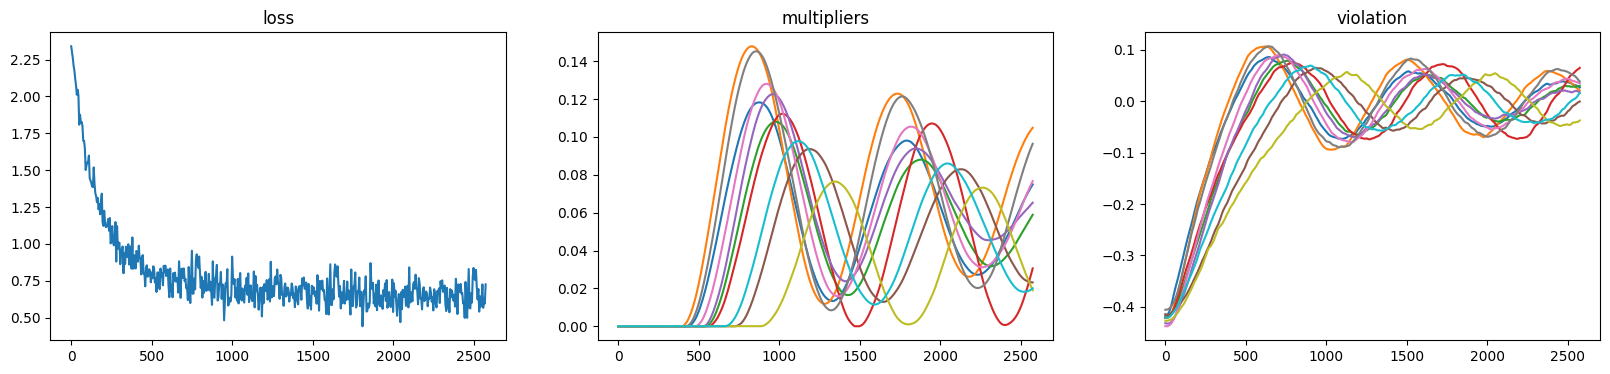

In [24]:
iters, loss_hist, multipliers_hist, violation_hist = zip(
        *[
            (k, v["loss"], v["multipliers"], v["violation"])
            for k, v in state_history.items()
        ]
    )

hist_list = [loss_hist, multipliers_hist, violation_hist]
hist_names = ["loss", "multipliers", "violation"]

_, ax = plt.subplots(1, len(hist_list), figsize=(20, 4))

for ax, hist, title in zip(ax, hist_list, hist_names):
    ax.plot(iters, torch.stack(hist).squeeze())
    ax.set_title(title)

In [26]:
total, correct = 0, 0
with torch.no_grad():
    for inputs, targets in DataLoader(val_set, batch_size=64):
        outputs = model.forward(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum()
accuracy = 100 * correct / total

accuracy

tensor(85.9400)